In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_data(path='dataset_wparticipant_v2.csv', sample_size=12000, random_state=123):
    """
    Preprocesses data by loading a sample, converting specific columns to binary, applying one-hot encoding, 
    and splitting into train/test sets.
    
    Args:
        path (str): Path to the dataset CSV file.
        sample_size (int): Number of rows to load.
        random_state (int): Random state for reproducibility.
        
    Returns:
        pd.DataFrame, pd.DataFrame: Training and test datasets.
    """
    # Total rows in the dataset
    total_rows = 6034221

    # Define rows to skip for random sampling
    if sample_size >= total_rows:
        print("The number of requested rows is greater than or equal to the total rows. Loading all data.")
        skip_rows = None
    else:
        rng = np.random.default_rng(random_state)
        skip_rows = set(np.random.choice(range(1, total_rows + 1), size=total_rows - sample_size, 
                                         replace=False)) #random_state=random_state
    
    # Load sampled data
    data = pd.read_csv(path, sep=';', skiprows=lambda x: x in skip_rows)
    
    # Filter invalid or zero total price rows
    data = data[data["sw_total_price_wdiscount"].notna() & (data["sw_total_price_wdiscount"] > 1000) & (data["total_amount"] > 1000)] # removing small amounts (non-commercial)
        
    data["target_amount"] = data["sw_total_price_wdiscount"] - 1

    # Total amount is a direct numeric feature. Scale non-direct numeric features (lot to ad ratio)
    data["sum_lot_ad_ratio"] = data["total_amount"]/data["ad_total_sum"]
    data["count_lot_ad_ratio"] = data["total_count"]/data["ad_lots_count"]
    
    # Select relevant columns
    cols_to_keep = [
        "target_amount", "fw_total_price_wdiscount", "total_amount", "sum_lot_ad_ratio", "count_lot_ad_ratio",
        "is_union_lots", "is_dumping", "plan_trade_method_id", "fact_trade_method_id", 
        "psd_sign", "is_consulting_services", "single_org_sign", "is_light_industry",
        "is_construction_work", "is_disable_person_advertisement", "ad_trade_method_id",
        "ad_subject_type_id", "ad_trade_type_id", "ad_disable_person_id", "ad_single_org_sign",
        "ad_is_light_industry", "ad_is_construction_work", "ad_purchase_type_id",
        "participant_creation_date", "participant_is_have_website", "participant_is_quazi", 
        "participant_is_national_company", "participant_kopf_code", 
        "participant_is_association_with_disabilities", "participant_registration_year",
        "participant_is_supplier", "participant_krp_code", "participant_parent_company",
        "participant_branches", "participant_oked_list", "participant_kse_code",
        "participant_is_world_company", "participant_is_state_monopoly",
        "participant_is_natural_monopoly"
    ]
    data = data[cols_to_keep]

    # 1. Transform 'psd_sign' to binary
    data['pds_sign'] = data['psd_sign'].apply(lambda x: 0 if x == 0 else 1)

    # 2. Transform 'participant_parent_company' to 'is_subsidiary'
    data['is_subsidiary'] = data['participant_parent_company'].apply(lambda x: 0 if pd.isnull(x) else 1)

    # 3. Transform 'participant_branches' to 'is_parent_company'
    data['is_parent_company'] = data['participant_branches'].apply(lambda x: 0 if pd.isnull(x) else 1)

    # Drop original columns after transformation
    data.drop(columns=["participant_parent_company", "participant_branches"], inplace=True)

    # categorical features are columns starting from "is_union_lots" and apply one-hot encoding
    cat_columns = data.columns[data.columns.get_loc("is_union_lots"):]
    data = pd.get_dummies(data, columns=cat_columns, drop_first=True)

    # 5. Remove rows with any NaN values
    # data = data.dropna()

    # 6. Train-test split
    X = data.drop(columns=["target_amount"])  # Features
    y = data["target_amount"]                # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    fw_amount_train = X_train["fw_total_price_wdiscount"]
    fw_amount_test = X_test["fw_total_price_wdiscount"]

    X_train = X_train.drop(columns=["fw_total_price_wdiscount"])
    X_test = X_test.drop(columns=["fw_total_price_wdiscount"])

    return X_train, X_test, y_train, y_test, fw_amount_train, fw_amount_test


In [2]:
X_train, X_test, y_train, y_test, fw_amount_train, fw_amount_test = preprocess_data(random_state = 4, sample_size = 16000)

In [3]:
X_train.shape, X_test.shape

((11574, 302), (2894, 302))

In [41]:
fw_amount_train.shape, fw_amount_train.shape

((8692,), (8692,))

Random Forest Regression Results:
Mean Squared Error: 430889214900536.25
Mean Absolute Error: 986664.08
Mean Absolute Percentage Error: 16078142635279265792.00
R² Score: 0.8984

Top 20 Important Features:
                                Feature  Importance
0                          total_amount    0.936868
33                  single_org_sign_3.0    0.014076
36             is_construction_work_4.0    0.013132
13           plan_trade_method_id_188.0    0.009709
22           fact_trade_method_id_188.0    0.009026
68                  ad_trade_type_id_60    0.002767
223         participant_oked_list_84113    0.002653
52                   ad_trade_type_id_3    0.002125
27                           psd_sign_9    0.001414
48               ad_trade_method_id_188    0.001175
53                   ad_trade_type_id_4    0.001102
82            ad_is_construction_work_4    0.000997
92        participant_is_have_website_1    0.000995
24                           psd_sign_4    0.000630
26             

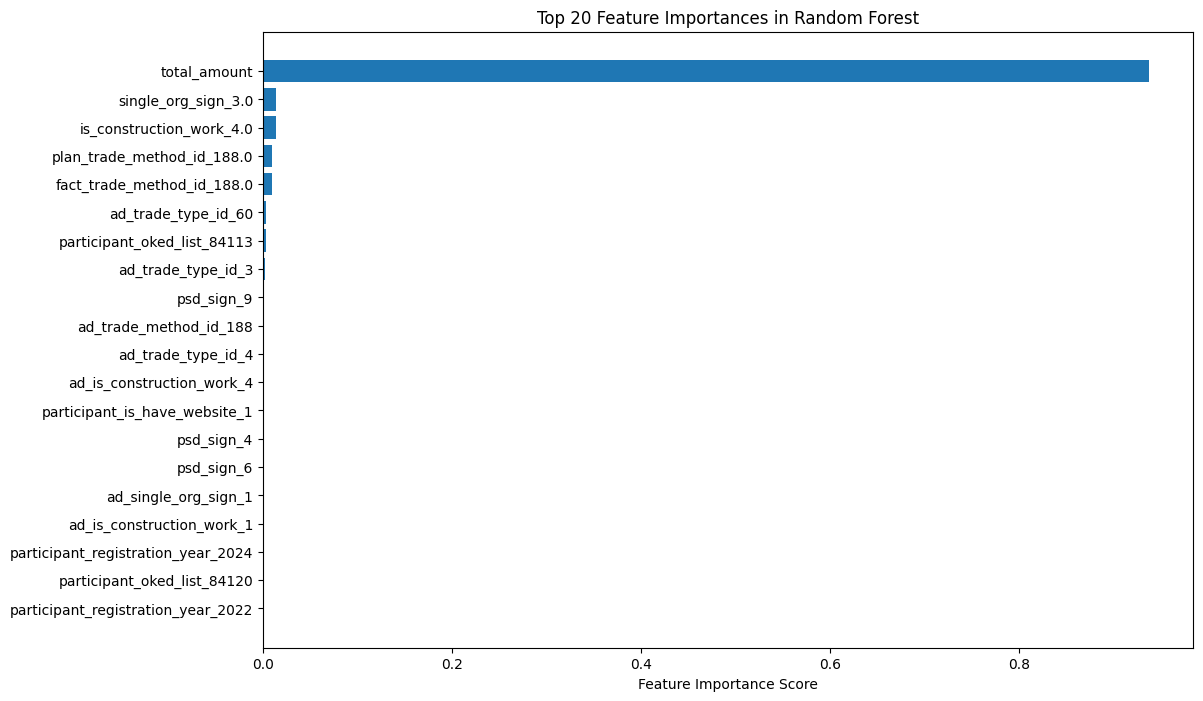

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    random_state=123,      # Reproducibility
    max_depth=15,          # Limit tree depth to avoid overfitting
    n_jobs=-1              # Use all CPU cores
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_p = mean_absolute_percentage_error(y_test, y_pred)


print(f"Random Forest Regression Results:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mae_p:.2f}")
print(f"R² Score: {r2:.4f}")

feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Convert to a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display Top Features
print("\nTop 20 Important Features:")
print(feature_importance_df.head(20))

# Plot Top 20 Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances in Random Forest")
plt.xlabel("Feature Importance Score")
plt.show()

In [84]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print(f"Multiple Linear Regression Results:")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"Root Mean Squared Error: {rmse_lr:.2f}")
print(f"Mean Absolute Error: {mae_lr:.2f}")
print(f"Mean Absolute Percentage Error: {mape_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")

Multiple Linear Regression Results:
Mean Squared Error: 9443118957000.40
Root Mean Squared Error: 3072965.82
Mean Absolute Error: 512877.17
Mean Absolute Percentage Error: 21175662713083932.00
R² Score: 0.9941


In [33]:
simple_lr = LinearRegression()
simple_lr.fit(X_train[["total_amount"]], y_train)

y_pred_simple_lr = simple_lr.predict(X_test[["total_amount"]])

mse_simple_lr = mean_squared_error(y_test, y_pred_simple_lr)
mae_simple_lr = mean_absolute_error(y_test, y_pred_simple_lr)
mape_simple_lr = mean_absolute_percentage_error(y_test, y_pred_simple_lr)
r2_simple_lr = r2_score(y_test, y_pred_simple_lr)

print(f"Multiple Linear Regression Results:")
print(f"Mean Squared Error: {mse_simple_lr:.2f}")
print(f"Mean Absolute Error: {mae_simple_lr:.2f}")
print(f"Mean Absolute Percentage Error: {mape_simple_lr:.2f}")
print(f"R² Score: {r2_simple_lr:.4f}")

Multiple Linear Regression Results:
Mean Squared Error: 70499054291056.77
Mean Absolute Error: 527772.17
Mean Absolute Percentage Error: 18400582961230319616.00
R² Score: 0.9834


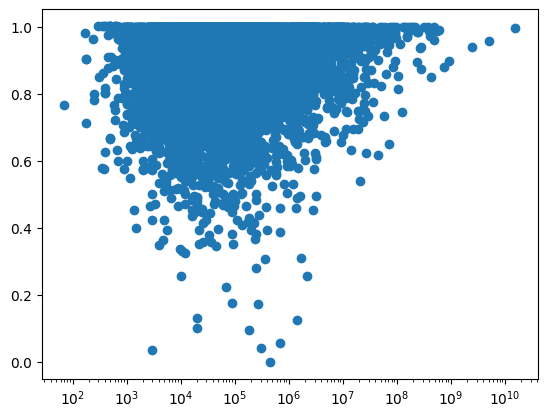

In [23]:
import matplotlib.pyplot as plt

sw_ratio =  fw_amount_train / y_train
plt.scatter(X_train["total_amount"], sw_ratio)
plt.xscale("log")
plt.show()

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

simple_lr = LinearRegression()
simple_lr.fit(X_train[["total_amount"]], y_train)

y_pred_simple_lr = simple_lr.predict(X_test[["total_amount"]])

rmse_simple_lr = np.sqrt(mean_squared_error(y_test, y_pred_simple_lr))
mae_simple_lr = mean_absolute_error(y_test, y_pred_simple_lr)
mape_simple_lr = mean_absolute_percentage_error(y_test, y_pred_simple_lr)
r2_simple_lr = r2_score(y_test, y_pred_simple_lr)

print(f"Multiple Linear Regression Results:")
print(f"Root Mean Squared Error: {rmse_simple_lr:.2f}")
print(f"Mean Absolute Error: {mae_simple_lr:.2f}")
print(f"Mean Absolute Percentage Error: {mape_simple_lr:.2f}")
print(f"R² Score: {r2_simple_lr:.4f}")

Multiple Linear Regression Results:
Root Mean Squared Error: 1957968.87
Mean Absolute Error: 411180.99
Mean Absolute Percentage Error: 18.83
Symmetric Mean Absolute Percentage Error: 155.62
R² Score: 0.9908


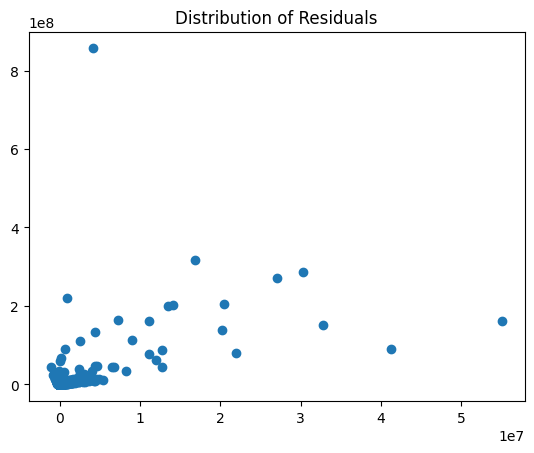

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_pred_simple_lr - y_test
plt.scatter(residuals, X_test["total_amount"])
plt.title("Distribution of Residuals")
plt.show()


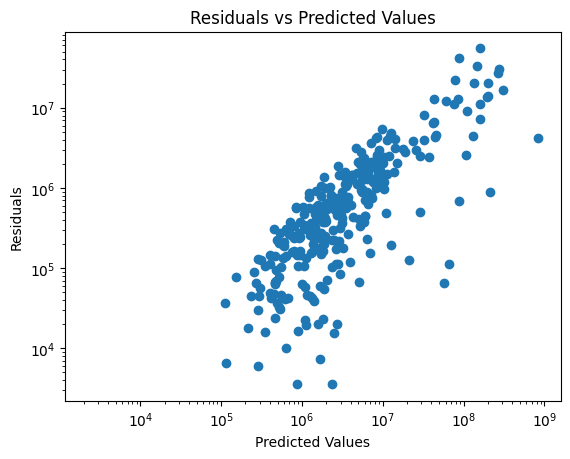

In [48]:
plt.scatter(y_pred_simple_lr, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [37]:
path='dataset_wparticipant_v2.csv'
sample_size=12000

data = pd.read_csv(path, sep = ";", nrows = 15000)
data = data[data["fw_total_price_wdiscount"]>0]

In [47]:
data[data["fw_total_price_wdiscount"]>data["total_amount"]]

,advertisement_id,lot_id,fw_item_price,fw_total_price,fw_discount,fw_total_price_wdiscount,sw_item_price,sw_total_price,sw_discount,sw_total_price_wdiscount,...,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_world_company,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_patronymic_producer,participant_is_patronymic_supplier,participant_is_small_employer,participant_is_single_org
239,11531782,29228585,35770.00,51100.0,0.0,51100.0,39200.00,56000.00,0.0,56000.00,...,1.507400e+11,86900,5,0,1,1,0,0,0,0
240,11531782,29228476,1054.00,42500.0,0.0,42500.0,1439.29,58035.71,0.0,58035.71,...,1.507400e+11,86900,5,0,1,1,0,0,0,0
275,11511489,29186926,12975.00,25950.0,0.0,25950.0,14720.00,29440.00,0.0,29440.00,...,1.507400e+11,86900,5,0,0,0,0,0,0,0
311,11493303,29150104,35000.00,175000.0,0.0,175000.0,35600.00,178000.00,0.0,178000.00,...,NaN,86210,5,0,0,0,0,0,0,0
318,11522526,29209157,1980.00,19800.0,0.0,19800.0,2500.00,25000.00,0.0,25000.00,...,1.507400e+11,86900,5,0,0,0,0,0,0,0
617,11383649,28933519,21000.00,2100000.0,0.0,2100000.0,31000.00,3100000.00,0.0,3100000.00,...,NaN,36000,5,0,0,1,0,0,0,0
618,11392629,28949368,6664.00,14000.0,0.0,14000.0,7650.00,16071.42,0.0,16071.42,...,1.507400e+11,86900,5,0,0,0,0,0,0,0
2877,10457219,27056568,259200.00,864000.0,0.0,864000.0,390000.00,1300000.00,0.0,1300000.00,...,NaN,35301,5,0,0,0,0,0,0,0
3613,10160732,26389421,1500.00,15000.0,0.0,15000.0,1607.14,16071.43,0.0,16071.43,...,NaN,86900,5,0,0,0,0,0,1,0
4889,9639294,25095042,2600.00,26000.0,0.0,26000.0,2850.00,28500.00,0.0,28500.00,...,NaN,84111,5,0,0,0,0,0,0,0


In [51]:
correlation_matrix = X_train.join(y_train).corr()
print(correlation_matrix["target_amount"].sort_values(ascending=False))


target_amount                    1.000000
total_amount                     0.999813
psd_sign_6                       0.306127
ad_is_construction_work_1        0.264160
ad_single_org_sign_2             0.260128
                                   ...   
participant_oked_list_1490.0          NaN
participant_oked_list_64193.0         NaN
participant_oked_list_82990.0         NaN
participant_oked_list_96040.0         NaN
participant_kse_code_8.0              NaN
Name: target_amount, Length: 303, dtype: float64


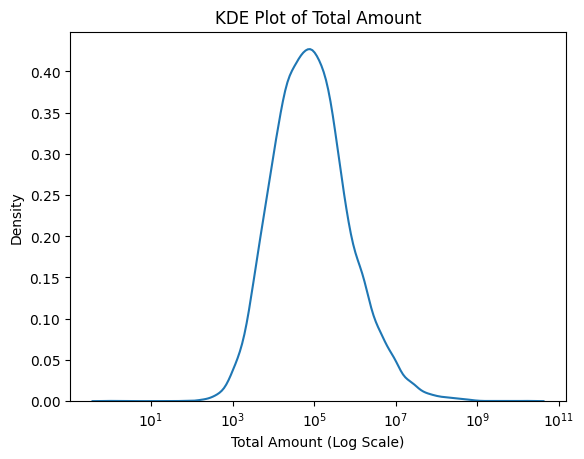

In [75]:
from scipy.stats import zscore

numeric_X_train = X_train.select_dtypes(include=['float64', 'int64'])

z_scores = np.abs(zscore(numeric_X_train["total_amount"]))
outliers = np.where(z_scores > 3)  # Values beyond 3 standard deviations

filtered_data = numeric_X_train["total_amount"][numeric_X_train["total_amount"] > 0]  # Exclude non-positive values for log scale
filtered_data = filtered_data[filtered_data < filtered_data.quantile(0.99)]  # Exclude extreme outliers

sns.kdeplot(data=numeric_X_train, x="total_amount", log_scale=True)
plt.xlabel("Total Amount (Log Scale)")
plt.title("KDE Plot of Total Amount")
plt.show()


<Axes: ylabel='target_amount'>

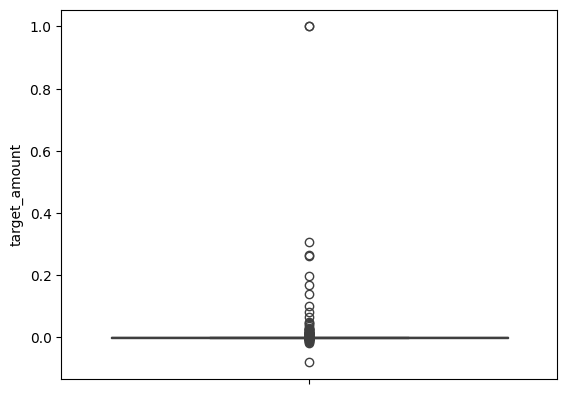

In [52]:
sns.boxplot(data=correlation_matrix, y="target_amount")


In [76]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(simple_lr, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean()}")

Cross-Validation R² Scores: [0.99381058 0.99891191 0.99870248 0.97100312 0.99173486]
Mean CV R²: 0.9908325904277371


In [ ]:
simple_lr = 

In [87]:
from sklearn.metrics import mean_squared_error, r2_score

train_preds = lr_model.predict(X_train)
test_preds = lr_model.predict(X_test)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Train R²: 0.9994762130429004
Test R²: 0.9940729465547044


In [3]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the regressor with pruning parameters
tree = DecisionTreeRegressor(
    max_depth=5,               # Limit depth to avoid overfitting
    min_samples_split=10,      # Minimum samples to split a node
    min_samples_leaf=5,        # Minimum samples in a leaf node
    max_leaf_nodes=50          # Restrict total leaf nodes
)

# Fit the tree to the training data
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=50, min_samples_leaf=5,
                      min_samples_split=10)

In [4]:
# Get the pruning path
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train trees for different ccp_alpha values
trees = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    reg.fit(X_train, y_train)
    trees.append(reg)

# Evaluate the trees on a validation set
from sklearn.metrics import mean_squared_error

mse_scores = [mean_squared_error(y_test, tree.predict(X_test)) for tree in trees]

# Find the best alpha
optimal_index = mse_scores.index(min(mse_scores))
optimal_alpha = ccp_alphas[optimal_index]

# Train the final tree with optimal ccp_alpha
final_tree = DecisionTreeRegressor(ccp_alpha=optimal_alpha)
final_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=903233008187.9443)

In [6]:
import matplotlib.pyplot as plt

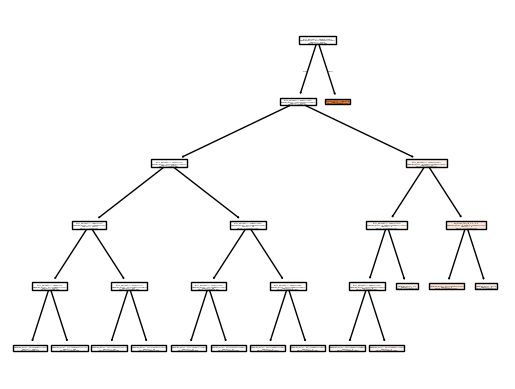

In [9]:
from sklearn.tree import plot_tree

plot_tree(final_tree, filled=True, feature_names=X_train.columns)
plt.savefig("dt.png", dpi = 3000)
plt.show()


Let's try MAPE as a loss function to minimize

In [3]:
from sklearn.metrics import make_scorer

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mape, greater_is_better=False)


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the grid search
param_grid = {'max_depth': [10, 20], 'n_estimators': [50, 100]}
grid_search = GridSearchCV(rf, param_grid, scoring=mape_scorer, cv=3)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

In [13]:
best_rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=20, random_state=42)>

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

y_pred_rf = best_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"Multiple Linear Regression Results:")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"Root Mean Squared Error: {rmse_rf:.2f}")
print(f"Mean Absolute Error: {mae_rf:.2f}")
print(f"Mean Absolute Percentage Error: {mape_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

Multiple Linear Regression Results:
Mean Squared Error: 4336318803996.80
Root Mean Squared Error: 2082382.96
Mean Absolute Error: 225177.50
Mean Absolute Percentage Error: 0.24
R² Score: 0.9815


In [20]:
pip install xgboost --upgrade


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
def mape_objective(y_true, y_pred):
    gradient = (y_pred - y_true) / (y_true * np.abs(y_true - y_pred))
    hessian = 1 / (y_true * np.abs(y_true - y_pred))
    return gradient, hessian

# Train the model
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
params = {'objective': 'reg:linear'}
model = xgb.train(params, dtrain, obj=mape_objective)


In [27]:
import lightgbm as lgb

def mape_loss(y_true, y_pred):
    diff = np.abs((y_true - y_pred) / y_true)
    return 'mape', np.mean(diff), False

# Train the model
train_data = lgb.Dataset(X_train, label=y_train)
params = {'objective': 'regression', 'metric': 'mape'}
model_lgb = lgb.train(params, train_data, feval=mape_loss)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 11460, number of used features: 142
[LightGBM] [Info] Start training from score 1990560.292077


In [28]:
y_pred_lgb = model_lgb.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)

print(f"Multiple Linear Regression Results:")
print(f"Mean Squared Error: {mse_lgb:.2f}")
print(f"Root Mean Squared Error: {rmse_lgb:.2f}")
print(f"Mean Absolute Error: {mae_lgb:.2f}")
print(f"Mean Absolute Percentage Error: {mape_lgb:.2f}")
print(f"R² Score: {r2_lgb:.4f}")

Multiple Linear Regression Results:
Mean Squared Error: 49879950450113.59
Root Mean Squared Error: 7062573.93
Mean Absolute Error: 600034.39
Mean Absolute Percentage Error: 0.61
R² Score: 0.7869


In [ ]:
from catboost import CatBoostRegressor

cb_model = CatBoostRegressor(loss_function='RMSE', eval_metric='MAPE', iterations=500)
cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)


In [ ]:
y_pred_lgb = cb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)

print(f"Multiple Linear Regression Results:")
print(f"Mean Squared Error: {mse_lgb:.2f}")
print(f"Root Mean Squared Error: {rmse_lgb:.2f}")
print(f"Mean Absolute Error: {mae_lgb:.2f}")
print(f"Mean Absolute Percentage Error: {mape_lgb:.2f}")
print(f"R² Score: {r2_lgb:.4f}")

In [4]:
X_train.shape

(11412, 311)

In [5]:
X_train[X_train["total_amount"]<fw_amount_train]

,total_amount,sum_lot_ad_ratio,count_lot_ad_ratio,is_union_lots_1,is_dumping_1,plan_trade_method_id_3.0,plan_trade_method_id_32.0,plan_trade_method_id_52.0,plan_trade_method_id_77.0,plan_trade_method_id_124.0,...,participant_kse_code_5.0,participant_kse_code_6.0,participant_kse_code_7.0,participant_kse_code_9.0,participant_is_world_company_1.0,participant_is_state_monopoly_1.0,participant_is_natural_monopoly_1.0,pds_sign_1,is_subsidiary_1,is_parent_company_1
705,1428.87,0.000566,0.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,True,False
10884,41178.00,0.015062,0.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
10710,2767.86,0.017765,0.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
7562,1560.00,0.006623,0.0,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,True
1184,103350.00,0.004670,0.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
470,3767.50,0.033707,0.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,True
3945,114285.71,0.031120,0.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
8380,12169.64,0.114406,0.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
12874,11607.14,0.002858,0.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
15591,4300.00,0.017512,0.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False


In [6]:
dataset = pd.read_csv("dataset_wparticipant_v2.csv", sep = ";")
dataset.shape

(6034221, 80)

In [11]:
dataset.ad_start_date.sort_values(ascending = False).head()

1340409    2024-12-05 09:00:00
2979594    2024-12-04 09:00:00
4008465    2024-12-04 09:00:00
3134658    2024-12-04 09:00:00
3948232    2024-12-04 09:00:00
Name: ad_start_date, dtype: object